## Real estate price prediction.

Description:
The real dataset of real estate parameters is given.
The task is to develop a model for a real estate agency to outperform its competitors in terms of the speed and quality of transactions. Study the structure of the data. Pre-process and clean the dataset. Perform EDA. Choose the best model and perform training and prediction.

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import category_encoders as ce
import json
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import shapiro
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from flask import Flask, request, jsonify
import pickle

In [107]:
!pip freeze > requirements.txt

## Loading dataset and exploring features

In [3]:
data = pd.read_csv('data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
data.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274071
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150716
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

In [6]:
#filling NA for a categoric feature
data['status'] = data['status'].fillna('unavailable')
#Modifying string values
data['status'] = data['status'].apply( lambda x: str(x).lower().replace(",", "").replace(".", "").replace(":", "").replace("   ", " ").replace(" / ", "/"))
data['status'].unique()

array(['active', 'for sale', 'unavailable', 'new construction', 'new',
       'pending', 'p', 'active/contingent', 'pre-foreclosure/auction',
       '/auction', 'under contract', 'under contract showing',
       'pre-foreclosure', 'under contract backups', 'foreclosure',
       'active under contract', 'foreclosed', 'option pending',
       'under contract show', 'for rent', 'auction', 'a active',
       'contingent', 'pending continue to show', 'price change',
       'back on market', 'active option', 'recently sold',
       'coming soon nov 21', 'contingent finance and inspection',
       'coming soon dec 4', 'p pending sale', 'coming soon nov 23',
       'active with contingencies', 'pending ab', 'pf', 'contingent show',
       'contract p', 'contingent take backup', 'apartment for rent',
       'backup contract', 'option contract', 'pending inspection',
       'active option contract', 'c', 'auction - active', 'pi',
       'due diligence period', 'contract contingent on buyer sale'

From these statuses we can create a several new variables on the basis of most popular words. Let's create new features

In [7]:
data['status'] = data['status'].replace('sh ', 'show ')

In [8]:
#Getting statuses options and their frequency
statuses = dict()

#Counting popular statuses with a function
def pop_st(status):
    if status not in statuses:
        statuses[status] = 1
    else:
        statuses[status] +=1

            
data['status'].apply(pop_st)
print(max(statuses.items(), key=lambda k: k[1]))

('for sale', 199571)


Taking a look on the statuses to create new features from the most popular ones.

In [9]:
for key, value in dict(sorted(statuses.items(), key=lambda item: item[1], reverse=True)).items():
    if value > 65:
        print(key, value)

for sale 199571
active 105207
unavailable 39918
foreclosure 6769
new construction 5475
pending 4807
pre-foreclosure 2119
pre-foreclosure/auction 1560
p 1488
under contract show 1183
/auction 936
under contract showing 793
active under contract 718
under contract 692
new 690
contingent 581
price change 563
auction 536
foreclosed 459
a active 443
for rent 398
recently sold 287
under contract backups 252
contingent finance and inspection 245
pending continue to show 198
contingent show 114
back on market 112
option pending 110


Creating categorical variables.

In [10]:
data['active'] = data['status'].apply(lambda x: 1 if ('active' in x) or ('activated' in x) or ('back on market' in x) or (('show' in x) and ('not' not in x) and ('no' not in x)) else 0)
data['new'] = data['status'].apply(lambda x: 1 if 'new' in x else 0)
data['auction'] = data['status'].apply(lambda x: 1 if 'auction' in x else 0)
data['contingency'] = data['status'].apply(lambda x: 1 if ('conting' in x) or ('option' in x) else 0)
data['inspection'] = data['status'].apply(lambda x: 1 if ('diligence' in x) or ('insp' in x) or ('pi' in x) else 0)
data['pending'] = data['status'].apply(lambda x: 1 if ('pending' in x) or ('p' in x) or ('pi' in x) else 0)
data['contract'] = data['status'].apply(lambda x: 1 if ('contract' in x) and ('conting' not in x) else 0)
data['backup'] = data['status'].apply(lambda x: 1 if ('back' in x) or ('offer' in x) or ('escape' in x) or ('listing' in x) else 0)
data['foreclosure'] = data['status'].apply(lambda x: 1 if ('foreclos' in x) or ('pf' in x) or ('fe' in x) else 0)
data['no_info'] = data['status'].apply(lambda x: 1 if ('unavailable' in x) else 0)
data['unavailable'] = data['status'].apply(lambda x: 1 if ('sold' in x) or ('accepted' in x) or ('closed' in x) or ('no show' in x) or ('not show' in x) else 0)
data['coming_soon'] = data['status'].apply(lambda x: 1 if ('coming soon' in x) else 0)
data['for_rent'] = data['status'].apply(lambda x: 1 if ('for rent' in x) or ('lease' in x) else 0)

In [11]:
data = data.drop('status', axis=1)

Transforming sqft to a numeric feature.

In [12]:
#Using regex to extract digits
data['sqft_mod'] = data['sqft'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x).replace(',', '')))
#Replacing the value for a specific case (value interval)
data['sqft_mod'].loc[330468,] = [sum(list(map(int,data['sqft_mod'].loc[330468,])))/len(data['sqft_mod'].loc[330468,])]
#Transforming into a numeric value
data['sqft_mod'] = data['sqft_mod'].apply(lambda x: int(float(x[0])) if len(x)>0 else np.nan)

C:\Users\user\AppData\Local\Temp\ipykernel_24076\655084326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqft_mod'].loc[330468,] = [sum(list(map(int,data['sqft_mod'].loc[330468,])))/len(data['sqft_mod'].loc[330468,])]


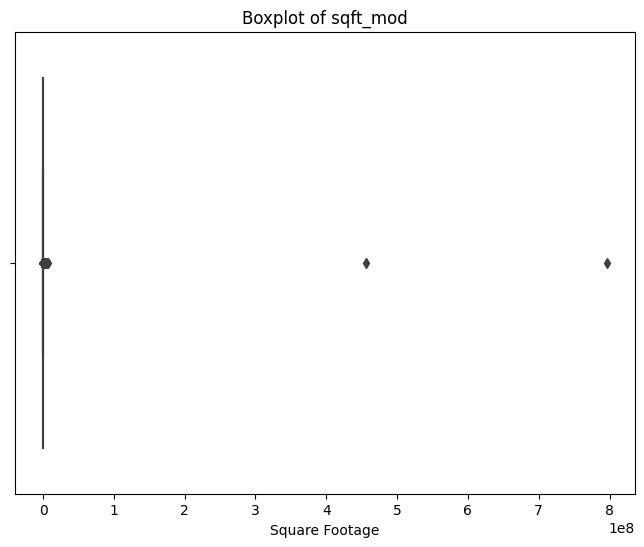

In [13]:
#Checking for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['sqft_mod'])
plt.title('Boxplot of sqft_mod')
plt.xlabel('Square Footage')
plt.show()

Values higher than 10,000 sqft seem to be implausible. Replacing them with NA.

In [14]:
data.loc[data['sqft_mod'] > 10000, 'sqft_mod'] = np.nan

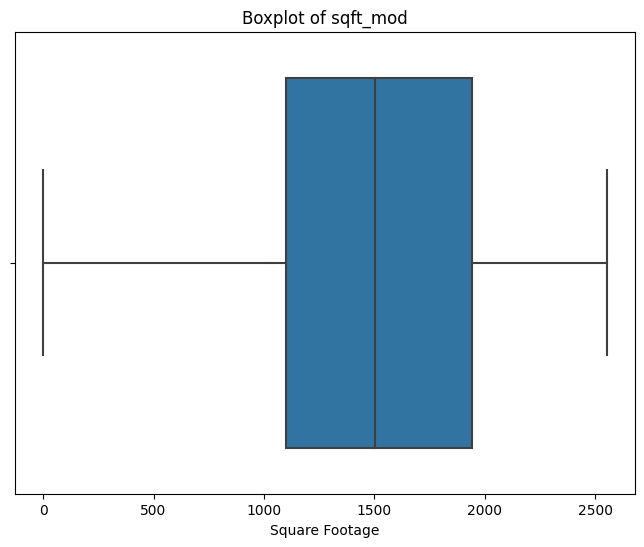

In [15]:
#Checking after modification
plt.figure(figsize=(8, 6))
sns.boxplot(x=data[data['sqft_mod'] < data['sqft_mod'].quantile(0.75)]['sqft_mod'])
plt.title('Boxplot of sqft_mod')
plt.xlabel('Square Footage')
plt.show()

No more outliers.

In [16]:
#Creating a new feature for the number of bathrooms
data['baths_mod'] = data['baths'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x).replace(',', '.')))

#A function to calculate the number of full and half baths
def baths_calculate(baths_num, type):
    '''
    A function to calculate the number of full or half baths.
    Parameters:
    type(string): half or full.
    Returns NaN or integers.
    '''
    #For a list of several items
    if len(baths_num) > 1:
        full_bath = 0
        half_bath = 0
        for index, bath in enumerate(baths_num):
            if index%2 == 0:
                full_bath += int(float(bath)) #calculating full baths
            else:
                half_bath += int(float(bath)) #calculating half baths
        if type == 'full':
            return int(full_bath)
        if type == 'half':
            return int(half_bath)
        #For a list of one item
    elif len(baths_num) == 1:
        if (float(baths_num[0])%1 == 0.5):
            if type == 'full':
                return int(float(baths_num[0])) #calculating full baths
            if type == 'half':
                return 1 #half baths
        elif (float(baths_num[0])%1 != 0):
            return None
        else:
            if type == 'full':
                return int(float(baths_num[0]))
            if type == 'half':
                return 0
    else:
        return None
    

In [17]:
#Trabsforming to integers and dropping the redundant features
data['baths_full'] = data['baths_mod'].apply(baths_calculate, type='full').astype('Int64')
data['baths_half'] = data['baths_mod'].apply(baths_calculate, type='half').astype('Int64')
data = data.drop(['baths_mod', 'baths'], axis=1)

Values higher than 20 and 55 are unlikely to be true. Replacing them with None.

In [18]:
data.loc[data['baths_half'] > 20, 'baths_half'] = None
data.loc[data['baths_full'] > 55, 'baths_full'] = None

In [19]:
#Calculating the percetnage of missing values and dropping
#uninformative features
print(round(data['private pool'].isna().sum()/data.shape[0], 3)*100)
data = data.drop(['private pool'], axis=1)
print(round(data['PrivatePool'].isna().sum()/data.shape[0], 3)*100)
data = data.drop(['PrivatePool'], axis=1)
print(round(data['fireplace'].isna().sum()/data.shape[0], 3)*100)
data = data.drop(['fireplace'], axis=1)
data = data.drop(['mls-id', 'MlsId'], axis=1)

98.9
89.3
72.7


In [20]:
#Calculating the number of sleeping places
data['beds'] = data['beds'].replace(to_replace=r'.*sqft.*', value=np.nan, regex=True)
data['beds_mod'] = data['beds'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x).replace(',', '')))
data['beds_mod'] = data['beds_mod'].apply(lambda x: int(float(x[0])) if len(x)>0 else np.nan).astype('Int64')

More than 20 bedrooms is an implausible value for a real estate, besides, there are errors in data placement according to its type. Replacing these row values with NA. 

In [21]:
data.loc[data['beds_mod'] > 20, 'beds_mod'] = np.nan
data = data.drop(['beds'], axis=1)

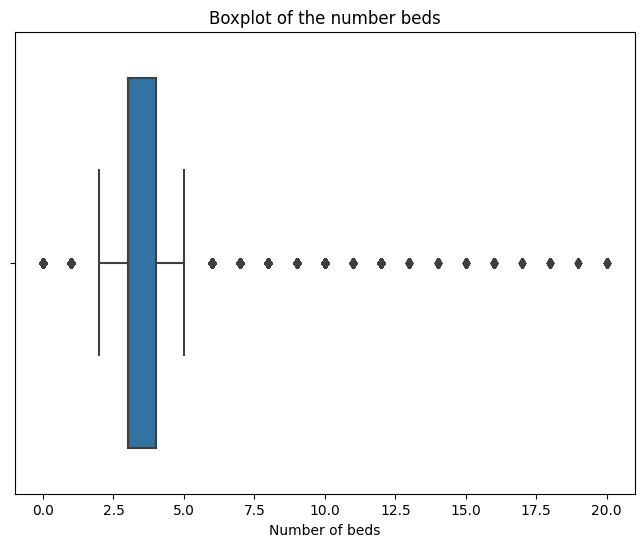

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['beds_mod'].dropna())
plt.title('Boxplot of the number beds')
plt.xlabel('Number of beds')
plt.show()

In [23]:
data['stories'].isna().sum()/data['stories'].shape[0]*100

39.958110741413364

The feature contains nearly 40% of the missing values. Since it represents the number of floors for an apartment, it can be unsafe to impute it even with the model values as the values are highly dependent on the apartment type. Wrong imputation can be misleading. It might be safer to drop the column.

In [24]:
data['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

This feature has to be encoded.

In [25]:
bin_encoder = ce.BinaryEncoder(cols=['state'])  #initialising the encoder
state_mod = bin_encoder.fit_transform(data['state']) #transforming
data = pd.concat([data, state_mod], axis=1) #concatenation
data = data.drop(['state'], axis=1) #dropping the redundant feature

In [26]:
#Modifying the schools feature to extract the info from it
data['schools_mod'] = data['schools'].apply(lambda x: x.replace("'", '"'))
data['schools_mod'] = data['schools_mod'].apply(lambda x: re.sub(r'(\w)"(\w)', r'\1\'\2', x)) #handling the apostrophes
data['schools_mod'] = data['schools_mod'].apply(lambda x: x.replace("\\'", "'"))

In [27]:
#Creating a function to extract info on
#distances to schools and their ratings
def extract_distance_rating(s):
    distance_pattern = r'"Distance": \[(.*?)\]'
    rating_pattern = r'"rating": \[(.*?)\]'

    distance_match = re.search(distance_pattern, s)[0].replace('"Distance": ', '').replace(" mi", "").replace("mi", "")
    rating_match = re.search(rating_pattern, s)[0].replace('"rating": ', '').replace("/10", "")
    
    return distance_match, rating_match

#Applying the extraction function
data[['distance_school', 'rating_school']] = data['schools_mod'].apply(lambda x: pd.Series(extract_distance_rating(x)))

In [28]:
#Defining a function to convert strings to numeric values
def convert_to_numeric(string_list):
    try:
        values = json.loads(string_list) #converting to json
    except (ValueError, json.JSONDecodeError):
        return []
    #Appending numeric and nan values to a list
    numerics = []
    for value in values:
        try:
            numerics.append(float(value))
        except (ValueError, TypeError):
            numerics.append(np.nan)
    return numerics

#Applying the function to the target features
data['distance_mean'] = data['distance_school'].apply(lambda x: round(np.nanmean(convert_to_numeric(x)), 2) if x else np.nan)
data['rating_mean'] = data['rating_school'].apply(lambda x: round(np.nanmean(convert_to_numeric(x)), 2) if x else np.nan)

C:\Users\user\AppData\Local\Temp\ipykernel_24076\21442432.py:17: RuntimeWarning: Mean of empty slice
  data['distance_mean'] = data['distance_school'].apply(lambda x: round(np.nanmean(convert_to_numeric(x)), 2) if x else np.nan)
C:\Users\user\AppData\Local\Temp\ipykernel_24076\21442432.py:18: RuntimeWarning: Mean of empty slice
  data['rating_mean'] = data['rating_school'].apply(lambda x: round(np.nanmean(convert_to_numeric(x)), 2) if x else np.nan)


In [29]:
#Dropping the redundant features
data = data.drop(['schools', 'schools_mod', 'distance_school', 'rating_school'], axis=1)

In [30]:
#Modifying the feature to extract the year of constriction
data['homeFacts_mod'] = data['homeFacts'].apply(lambda x: x.replace("'", '"').replace('None', '"None"'))

#Defining a function to create the year of construction
def extract_year(s):
    pattern =  r'{"factValue": "\d{4}", "factLabel": "Year built"}' #regex to search for the pattern
    match = re.search(pattern, s)
    if match:
        year = re.findall(r'\d+\.\d+|\d+', str(match[0]))[0] #searching for digits in a pattern
        return year
    else:
        return

#Applying to a feature   
data['year_const'] = data['homeFacts_mod'].apply(lambda x: extract_year(x))
data['year_const'] = data['year_const'].fillna(data['year_const'].mode())
data['year_const'] = data['year_const'].astype('Int64')

In [31]:
#Modifying the feature to further process it
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())

Let's create another features from the property type column. We can extract unique patterns and calculate an approximate number of them.

In [32]:
types = data['propertyType'].to_list()

#A function to extract unique patterns
def unique_words(types):
    #Creating a list of unique types
    typelist = []
    for type in types:
        localtype = type.split(', ')
        for type in localtype:
            typelist.append(type.replace("/", " ").replace("  ", ' ').replace("   ", " "))
    return typelist

unique_words(types)

['single family home',
 'single-family home',
 'single-family home',
 'single-family home',
 'lot land',
 'townhouse',
 'florida',
 'nan',
 'single family home',
 'single family',
 'coop',
 'english',
 'single-family home',
 'single family',
 'single family',
 '2 story',
 'nan',
 'townhouse',
 'single-family home',
 'multi-family',
 'single family',
 'single family',
 'penthouse',
 'split-level',
 'single-family home',
 'single-family home',
 'single-family home',
 'nan',
 'single-family home',
 'single-family home',
 'coop',
 'multi-family home',
 'single family',
 'single-family home',
 'condo',
 'single-family home',
 'condo',
 'single family',
 'single family',
 'single family',
 'condo',
 'nan',
 'lot land',
 'nan',
 'single-family home',
 'condo',
 'single family home',
 'single family',
 'single-family home',
 'nan',
 'land',
 'lot land',
 'condo',
 'condo',
 'single-family home',
 'single-family home',
 'single family home',
 'condo townhome row home co-op',
 'townhouse',
 'sin

In [33]:
popular_types = dict()

#Counting popular types with a function
def pop_types(typelist):
    for type in typelist:
        type.replace("/", " ").replace("  ", ' ').replace("   ", " ")
        if type not in popular_types:
            popular_types[type] = 1
        else:
            popular_types[type] += 1

pop_types(types)
print(max(popular_types.items(), key=lambda k: k[1]))

('single-family home', 92206)


Let's get the most frequent types.

In [34]:
for key, value in dict(sorted(popular_types.items(), key=lambda item: item[1], reverse=True)).items():
    if value > 100:
        print(key, value)

single-family home 92206
single family 62869
condo 42529
nan 34733
single family home 31728
lot/land 20552
townhouse 18400
land 10934
multi-family 7921
condo/townhome/row home/co-op 7701
traditional 5913
coop 3266
multi family 2794
high rise 1823
ranch 1781
mobile/manufactured 1618
detached, one story 1614
single detached, traditional 1581
contemporary 1557
multi-family home 1501
1 story 1235
colonial 1205
mobile / manufactured 1066
contemporary/modern 1000
apartment 922
2 stories 911
mfd/mobile home 792
single detached 751
detached, two story 638
one story 592
transitional 560
cooperative 535
florida 530
bungalow 442
farms/ranches 371
two story 312
garden home 305
2 story 282
cape cod 281
2 stories, traditional 280
spanish/mediterranean 272
other style 249
1 story, traditional 237
other 232
condo/townhome, traditional 225
singlefamilyresidence 220
craftsman 201
contemporary/modern, traditional 200
condo/townhome 183
condo/townhome, contemporary/modern 180
single detached, contemporary

Creating seemingly most useful features.

In [35]:
data['single_multi'] = data['propertyType'].apply(
    lambda x: 1 if ('single' in x and 'fam' in x) or ('detach' in x) or ('tiny' in x) 
    else 2 if ('multi' in x and 'fam' in x) else 0
)
data['can_be_bought'] = data['propertyType'].apply(
    lambda x: 1 if 'condo' in x else 2 if 'apart' in x or 'flat' in x else 0
)
data['townhouse'] = data['propertyType'].apply(
    lambda x: 1 if 'townh' in x else 0
)
data['coop'] = data['propertyType'].apply(
    lambda x: 1 if 'co-op' in x or 'coop' in x else 0
)
data['ranch'] = data['propertyType'].apply(
    lambda x: 1 if 'ranch' in x or 'farm' in x else 0
)
data['bungalow'] = data['propertyType'].apply(
    lambda x: 1 if 'bung' in x else 0
)
data['land'] = data['propertyType'].apply(
    lambda x: 1 if 'land' in x or 'lot' in x else 0
)
data['mobile'] = data['propertyType'].apply(
    lambda x: 1 if 'mobile' in x or 'mo2 le' in x or 'mo2le' in x or 'manuf' in x else 0
)
data['cont_trad'] = data['propertyType'].apply(
    lambda x: 1 if 'cont' in x or 'modern' in x 
    else 2 if 'trad' in x 
    else 3 if ('cont' in x and 'trad' in x) or 'transit' in x else 0
)
data['two_story'] = data['propertyType'].apply(
    lambda x: 1 if '2 stor' in x or 'two stor' in x or 'bilevel' in x else 0
)
data['penthouse'] = data['propertyType'].apply(
    lambda x: 1 if 'penth' in x else 0
)

In [36]:
#Dropping the redundant features
data = data.drop('propertyType', axis = 1)
data = data.drop(['street', 'city', 'sqft'], axis=1)

In [37]:
#Getting rid of a useless variable
print(data['stories'].isna().sum()/data['stories'].shape[0]*100)
data = data.drop('stories', axis=1)

39.958110741413364


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   homeFacts      377185 non-null  object 
 1   zipcode        377185 non-null  object 
 2   target         374704 non-null  object 
 3   active         377185 non-null  int64  
 4   new            377185 non-null  int64  
 5   auction        377185 non-null  int64  
 6   contingency    377185 non-null  int64  
 7   inspection     377185 non-null  int64  
 8   pending        377185 non-null  int64  
 9   contract       377185 non-null  int64  
 10  backup         377185 non-null  int64  
 11  foreclosure    377185 non-null  int64  
 12  no_info        377185 non-null  int64  
 13  unavailable    377185 non-null  int64  
 14  coming_soon    377185 non-null  int64  
 15  for_rent       377185 non-null  int64  
 16  sqft_mod       332671 non-null  float64
 17  baths_full     263493 non-nul

Modifying the target variable.

In [39]:
#Creeating a function to extract digits
def extract_value(s):
    s = re.findall(r'\d+\.\d+|\d+', str(s))
    if s:
        s = int(float(s[0]))
        return s
    else:
        return pd.NA

#Modifying
data['target_mod'] = data['target'].apply(lambda x: str(x).replace(",", ""))
data['target_mod'] = data['target_mod'].apply(lambda x: extract_value(x))

In [40]:
#Dropping another redundant variables
data = data.drop(['homeFacts_mod', 'homeFacts'], axis=1)

Let's copy the cleaned datatset for further modification.

In [41]:
data_proc = data.copy()
data_proc = data_proc.drop(['target'], axis=1)
data_proc = data_proc.drop(['zipcode'], axis=1)

Dropping duplicates

In [42]:
data_proc.duplicated().sum()
data_cleaned = data_proc.drop_duplicates()

Dropping rows with NA values for the target variable.

In [43]:
data_cleaned = data_cleaned.dropna(subset=['target_mod'])
data_cleaned['target_mod'] = data_cleaned['target_mod'].apply(lambda x: int(float(x)))

Filling NA for other variables according to the most suitable way and the corresponding percentages of missing values.

In [44]:
na_list = list()

#Calculating the percentages of missing values
for feature in data_cleaned.columns.to_list():
    if data_cleaned[feature].isna().sum() !=0:
        percentage = round(data_cleaned[feature].isna().sum()/data_cleaned.shape[0]*100, 2)
        print('The feature {} contains {} % missing values.'.format(feature, percentage))
        na_list.append(feature)

The feature sqft_mod contains 11.41 % missing values.
The feature baths_full contains 29.76 % missing values.
The feature baths_half contains 29.69 % missing values.
The feature beds_mod contains 28.91 % missing values.
The feature distance_mean contains 1.04 % missing values.
The feature rating_mean contains 1.28 % missing values.
The feature year_const contains 16.32 % missing values.


In [45]:
#Filling missing values
data_cleaned['baths_full'] = data_cleaned['baths_full'].fillna(data_cleaned['baths_full'].mode()[0])
data_cleaned['baths_half'] = data_cleaned['baths_half'].fillna(data_cleaned['baths_half'].mode()[0])
data_cleaned['beds_mod'] = data_cleaned['beds_mod'].fillna(data_cleaned['beds_mod'].mode()[0])
data_cleaned['distance_mean'] = data_cleaned['distance_mean'].fillna(data_cleaned['distance_mean'].median())
data_cleaned['rating_mean'] = data_cleaned['rating_mean'].fillna(data_cleaned['rating_mean'].median())
data_cleaned['sqft_mod'] = data_cleaned['sqft_mod'].fillna(data_cleaned['sqft_mod'].median())

In [46]:
#Imputing missing values with a model
missing_idx = data_cleaned[data_cleaned['year_const'].isnull()].index #calculating indexes of NA
#Splitting the dataset
train_df = (data_cleaned.dropna(subset=['year_const'])).drop(['target_mod'], axis=1)
test_df = data_cleaned.drop(['target_mod'], axis=1)[data_cleaned.drop(['target_mod'], axis=1)['year_const'].isnull()]
#Creating and fitting a model
fill_year = linear_model.LinearRegression()
fill_year.fit(train_df.drop(['year_const'], axis=1), train_df['year_const'])
#Prediciting and filling
predictions = fill_year.predict(test_df.drop(['year_const'], axis=1))
predictions_list = [int(i) for i in predictions]
data_cleaned.loc[missing_idx, 'year_const'] = predictions_list

Saving a cleaned dataset.

In [47]:
data_cleaned.to_csv('data_real_estate_cleaned.csv')

In [48]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369157 entries, 0 to 377184
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   active         369157 non-null  int64  
 1   new            369157 non-null  int64  
 2   auction        369157 non-null  int64  
 3   contingency    369157 non-null  int64  
 4   inspection     369157 non-null  int64  
 5   pending        369157 non-null  int64  
 6   contract       369157 non-null  int64  
 7   backup         369157 non-null  int64  
 8   foreclosure    369157 non-null  int64  
 9   no_info        369157 non-null  int64  
 10  unavailable    369157 non-null  int64  
 11  coming_soon    369157 non-null  int64  
 12  for_rent       369157 non-null  int64  
 13  sqft_mod       369157 non-null  float64
 14  baths_full     369157 non-null  Int64  
 15  baths_half     369157 non-null  Int64  
 16  beds_mod       369157 non-null  Int64  
 17  state_0        369157 non-null  in

Let's check for normality of continuous variables.

In [49]:
num_cols = ['sqft_mod', 'distance_mean', 'rating_mean']

for feature in num_cols:
    stat, p_value = shapiro(data_cleaned[feature])
    print('Shapiro-Wilk Test Statistic:', stat)
    print('P-Value:', p_value)
    if p_value > 0.05:
        print("{} is NOT normally distributed".format(feature))
    else:
        print("{} is normally distributed".format(feature))

Shapiro-Wilk Test Statistic: 0.8551045656204224
P-Value: 0.0
sqft_mod is normally distributed
Shapiro-Wilk Test Statistic: 0.20586633682250977
P-Value: 0.0
distance_mean is normally distributed
Shapiro-Wilk Test Statistic: 0.9870543479919434
P-Value: 0.0
rating_mean is normally distributed


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The features are normally distriburted, can be standardised. Standardising continuous features: sqft_mod, distance_mean, rating_mean.

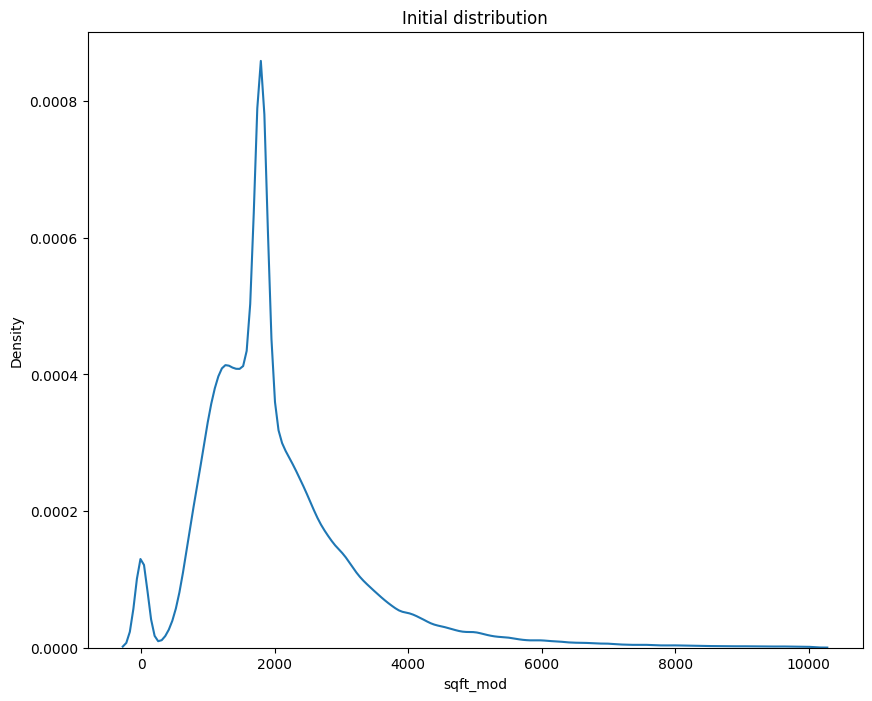

In [50]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Initial distribution')
sns.kdeplot(data_cleaned['sqft_mod'], ax=ax1, label ='sqft_mod');

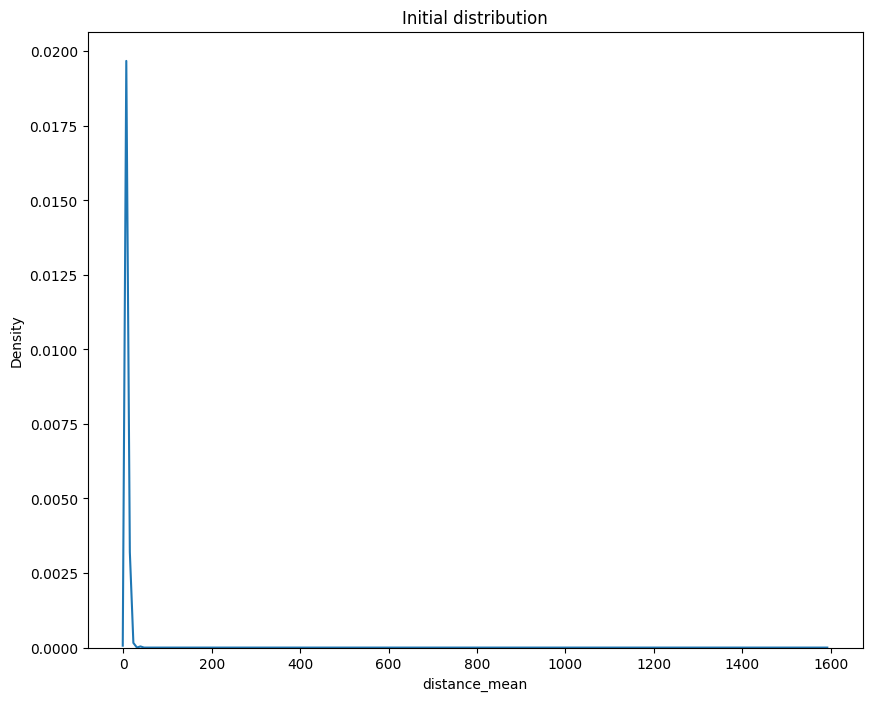

In [51]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Initial distribution')
sns.kdeplot(data_cleaned['distance_mean'], ax=ax1, label ='distance_mean');

In [52]:
#Getting rid of outliers
data_cleaned = data_cleaned[data_cleaned['distance_mean'] < 20]

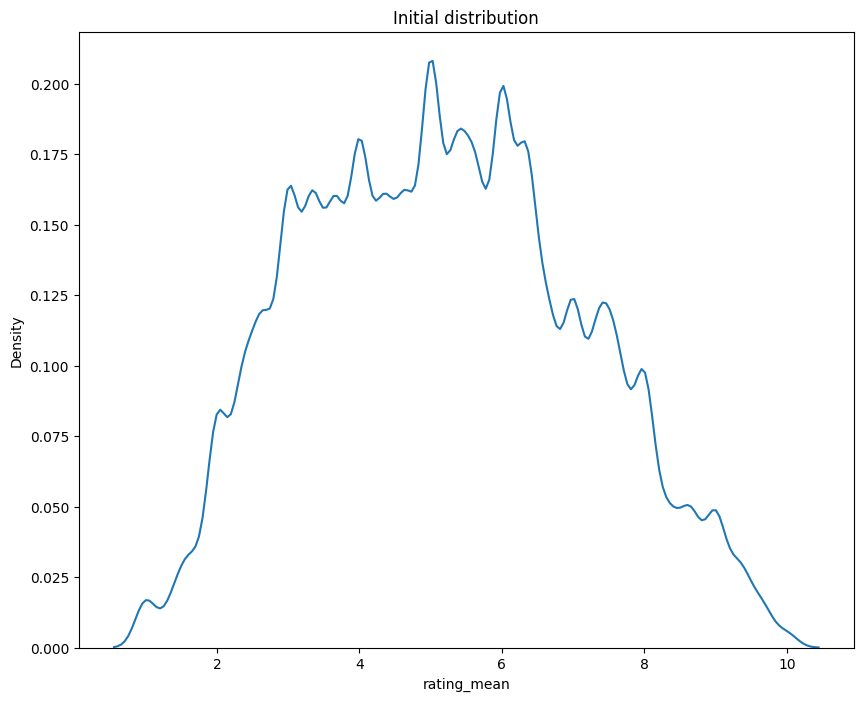

In [53]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Initial distribution')
sns.kdeplot(data_cleaned['rating_mean'], ax=ax1, label ='rating_mean');

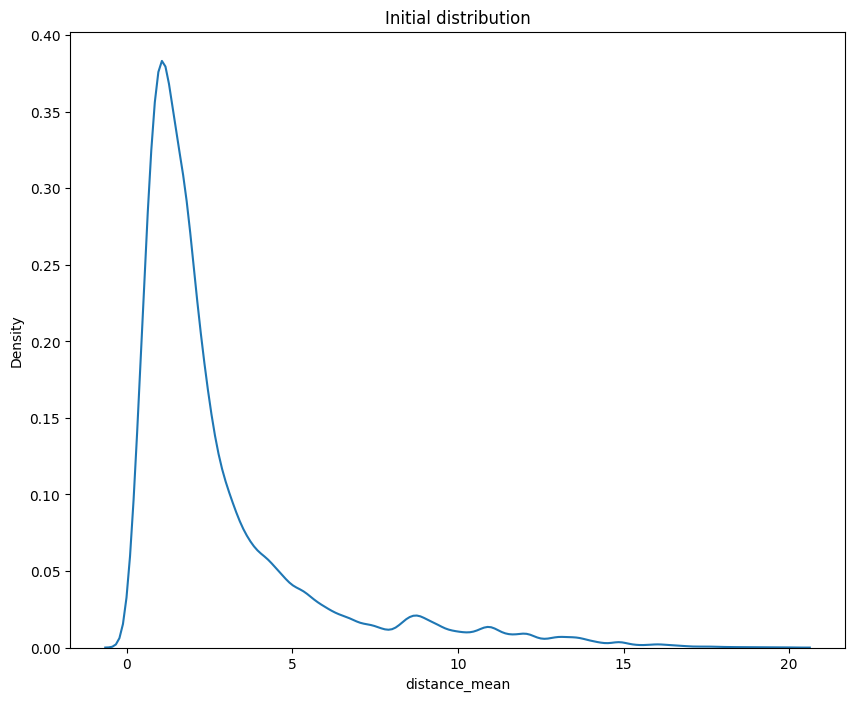

In [54]:
#Checking once more
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Initial distribution')
sns.kdeplot(data_cleaned['distance_mean'], ax=ax1, label ='distance_mean');

Applying another transformation to minimise the effect of extreme values.

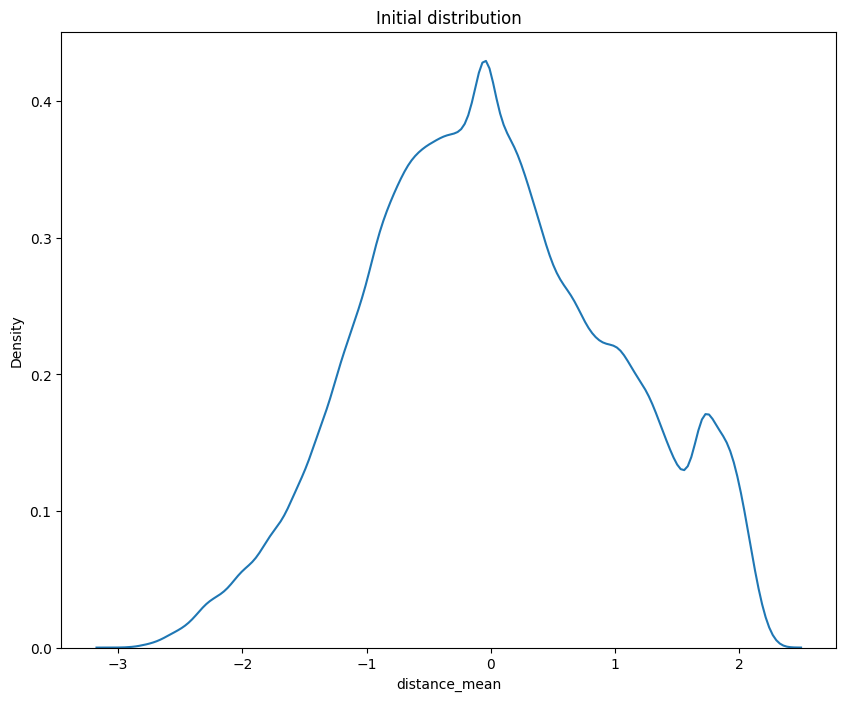

In [55]:
#Transformation
pt = PowerTransformer(method='yeo-johnson')
data_cleaned[['rating_mean', 'distance_mean', 'sqft_mod']] = pt.fit_transform(data_cleaned[['rating_mean', 'distance_mean', 'sqft_mod']])

#Checking the distribution
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Initial distribution')
sns.kdeplot(data_cleaned['distance_mean'], ax=ax1, label ='distance_mean');

In [56]:
scaler = StandardScaler()
data_cleaned[['rating_mean', 'distance_mean', 'sqft_mod']] = scaler.fit_transform(data_cleaned[['rating_mean', 'distance_mean', 'sqft_mod']])

Encoding categoric features.

In [57]:
#Creating the encoder and tranforming
encoder = ce.OneHotEncoder(cols=['single_multi', 'can_be_bought', 'cont_trad'], use_cat_names=True)
type_cat = encoder.fit_transform(data_cleaned[['single_multi', 'can_be_bought', 'cont_trad']])
data_cleaned = pd.concat([data_cleaned, type_cat], axis=1)
data_cleaned = data_cleaned.drop(['single_multi', 'can_be_bought', 'cont_trad'], axis=1)

Analysing the target variable

In [58]:
stat, p_value = shapiro(data_cleaned['target_mod'])
print('Shapiro-Wilk Test Statistic:', stat)
print('P-Value:', p_value)
if p_value > 0.05:
    print("'traget_mod' is NOT normally distributed.")
else:
    print("'traget_mod' is normally distributed.")

Shapiro-Wilk Test Statistic: 0.21417677402496338
P-Value: 0.0
'traget_mod' is normally distributed.


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


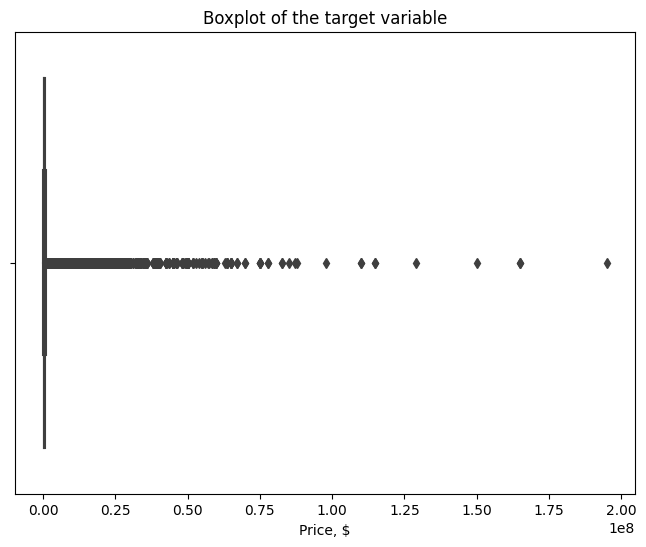

In [59]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['target_mod'])
plt.title('Boxplot of the target variable')
plt.xlabel('Price, $')
plt.show()

The target variable contains obious outliers. To mitigate the risk of their influence on the model quality and increase its robustness, let's cut off upper and lower quantiles of data.

In [60]:
lower_bound = data_cleaned['target_mod'].quantile(0.01)
upper_bound = data_cleaned['target_mod'].quantile(0.99)
filtered_data = data_cleaned[(data_cleaned['target_mod'] >= lower_bound) & (data_cleaned['target_mod'] <= upper_bound)]

Feature selection

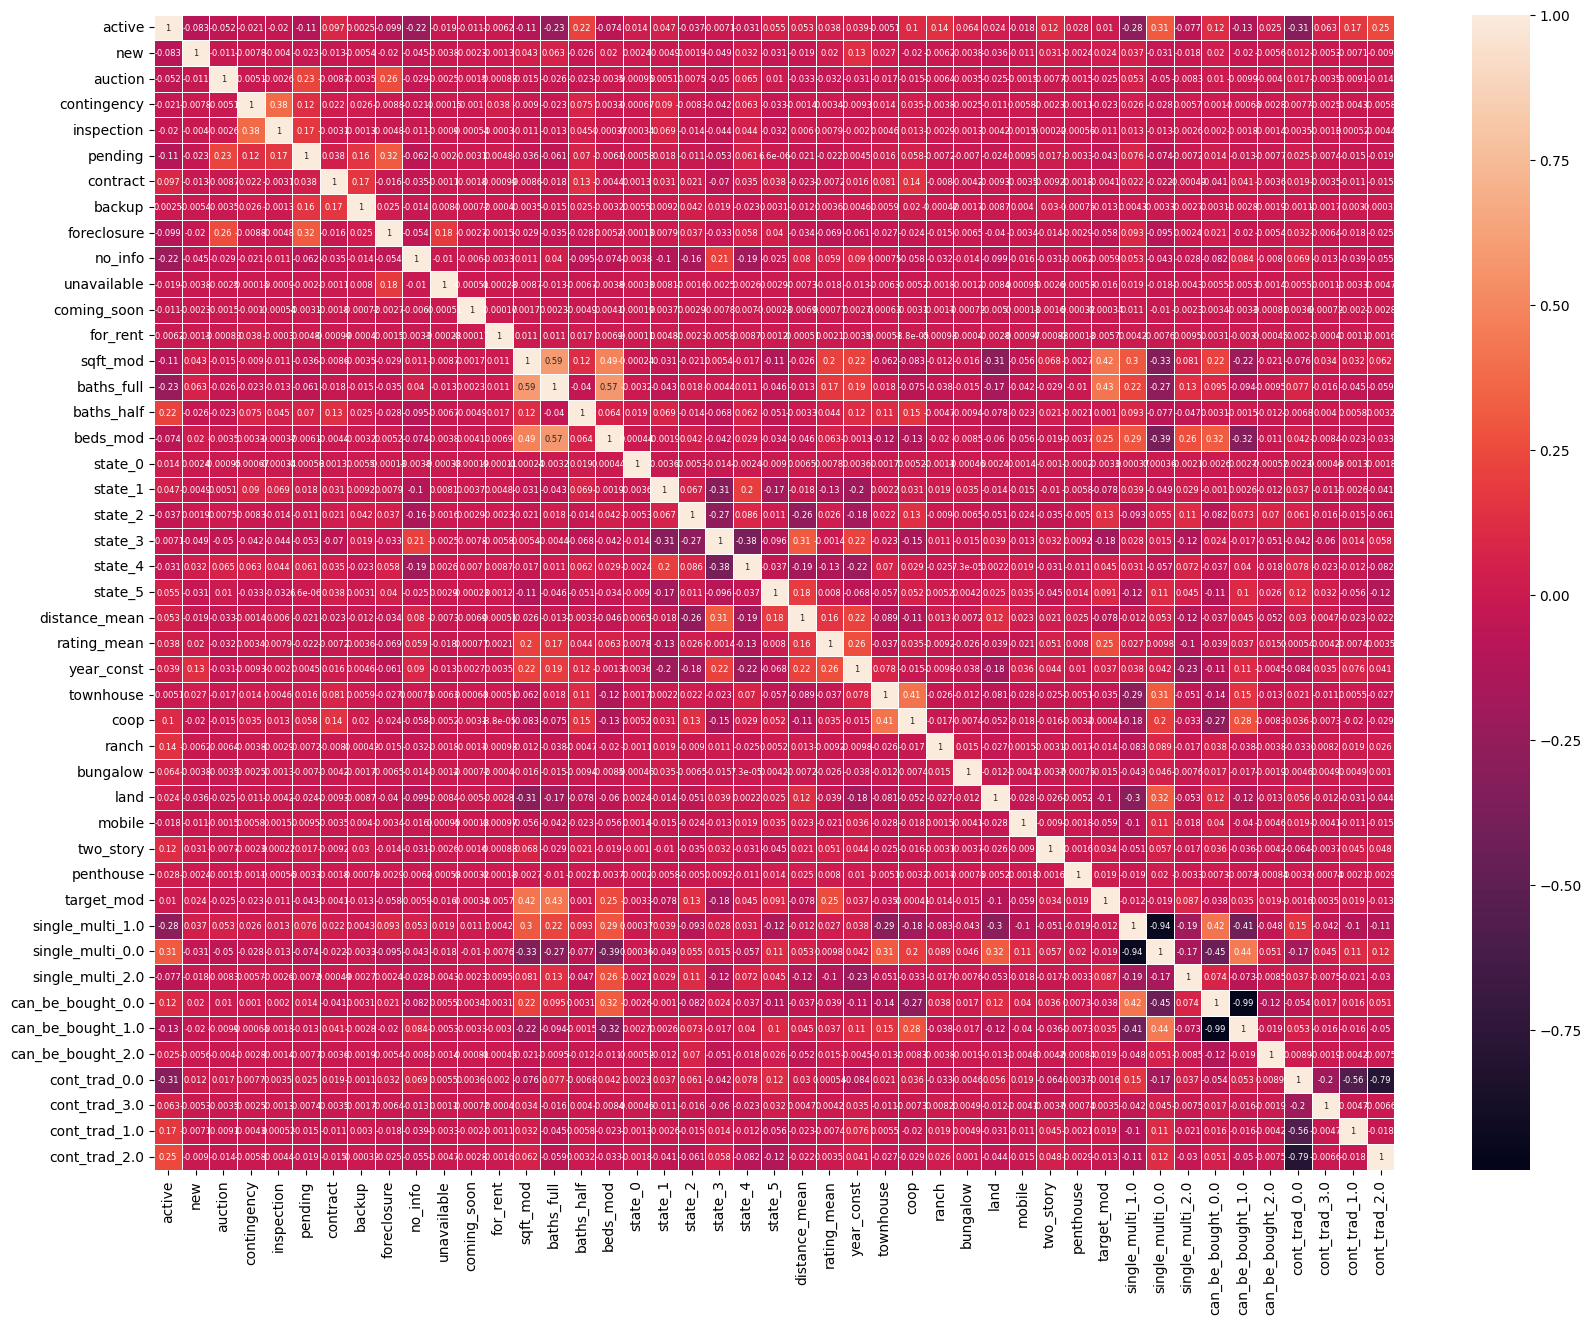

In [61]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(filtered_data.select_dtypes(include=['number']).corr(), annot=True, linewidths=.5, ax=ax, annot_kws={"size": 6});

Obviously, several encoded categoric variables show strong correlations (>|0/7|). Dropping them.

In [62]:
filtered_data = filtered_data.drop(['can_be_bought_0.0','cont_trad_0.0', 'single_multi_0.0'], axis=1)

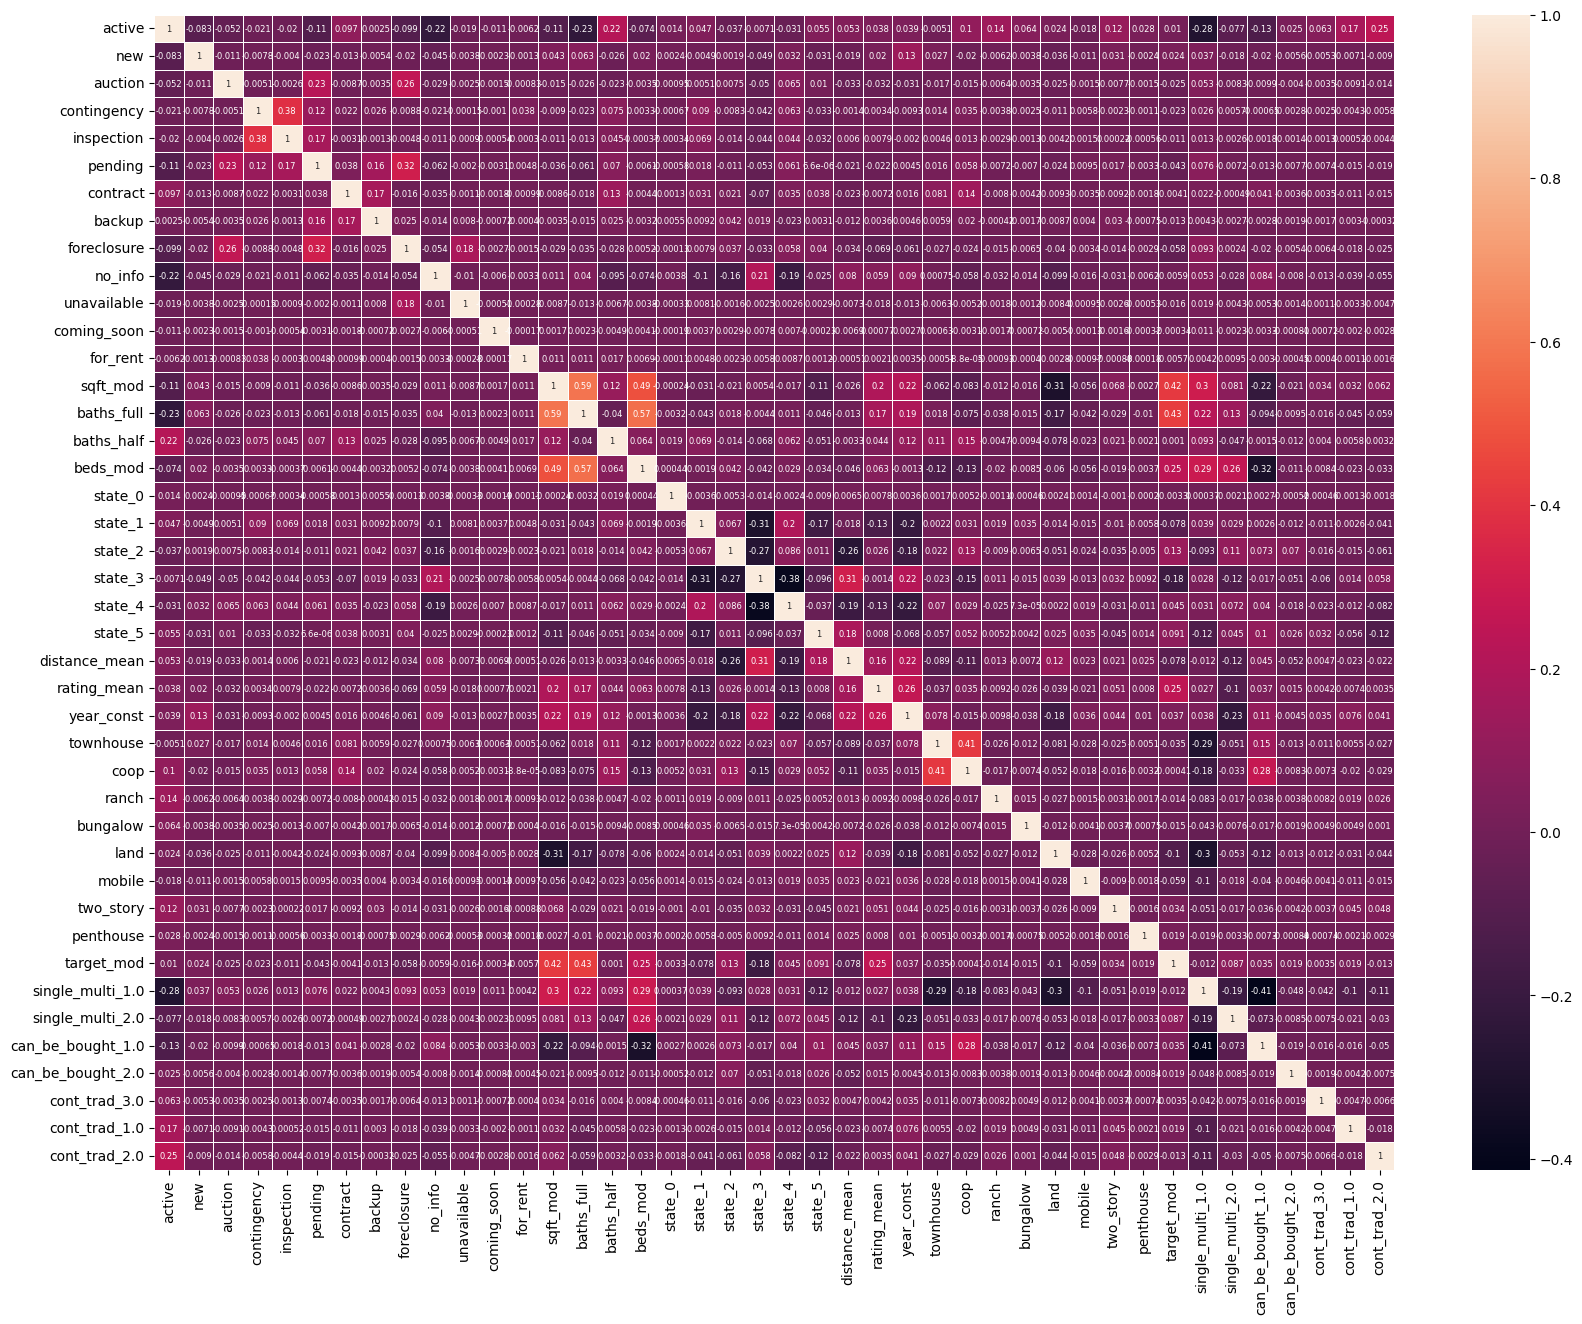

In [63]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(filtered_data.select_dtypes(include=['number']).corr(), annot=True, linewidths=.5, ax=ax, annot_kws={"size": 6});

No more strong correlations (>|0.7|) are observed. Passing to a baseline.

# Baseline model

In [64]:
#Splitting the dataset into the target variable and features
X = filtered_data.drop(['target_mod'], axis=1)
y = filtered_data['target_mod']
#Splitting the sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's create a basic regression model. MAE can be the metric of quality since our data contained outlier-like observations for several features. Let's also try MAPE for a clearer representation of the quality.

In [65]:
#LinearRegression object
lr_base = linear_model.LinearRegression()
#Training the model
lr_base.fit(X_train, y_train)
y_train_pred = lr_base.predict(X_train)
y_pred = lr_base.predict(X_test)

print('MAE_test:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE_test:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('MAE_train:', metrics.mean_absolute_error(y_train, y_train_pred))
print('MAPE_train:', metrics.mean_absolute_percentage_error(y_train, y_train_pred))

MAE_test: 314539.45498412906
MAPE_test: 1.7891474059831112
MAE_train: 315674.9641109445
MAPE_train: 1.7422678624419603


Let's try to improve our basic model.

# Improving the baseline

Let's select top N variables of most impact on the target variable.

In [66]:
len(filtered_data.columns) #The total number of features

42

In [67]:
selector = SelectKBest(score_func=f_regression, k=15)  # Select top features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

#Training the model on the selected features
lr_sl = linear_model.LinearRegression()
lr_sl.fit(X_train_selected, y_train)
y_train_pred_sl = lr_sl.predict(X_train_selected)
y_pred_sl = lr_sl.predict(X_test_selected)
print('MAE_test:', metrics.mean_absolute_error(y_test, y_pred_sl))
print('MAPE_test:', metrics.mean_absolute_percentage_error(y_test, y_pred_sl))
print('MAE_train:', metrics.mean_absolute_error(y_train, y_train_pred_sl))
print('MAPE_train:', metrics.mean_absolute_percentage_error(y_train, y_train_pred_sl))

MAE_test: 319728.6854874527
MAPE_test: 1.7263257272579458
MAE_train: 320168.13296910626
MAPE_train: 1.6730661119970864


On tweaking the parameters (k=10, 15, 20), the optimal metrics value was observed for k=15.

In [68]:
selector.get_feature_names_out()

array(['pending', 'foreclosure', 'sqft_mod', 'baths_full', 'beds_mod',
       'state_1', 'state_2', 'state_3', 'state_4', 'state_5',
       'distance_mean', 'rating_mean', 'land', 'mobile',
       'single_multi_2.0'], dtype=object)

The metrics improved. Let's further enhance the complexity of the model.

First, the dimention reduction and polynomial regression can be tried.

In [69]:
#Applying PCA
pca = PCA(n_components=0.95)  # retaining 95% of variance
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

#Creating polynomial features
poly = PolynomialFeatures(degree=3)  
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.transform(X_test_pca)

#Fitting the polynomial regression model
model = linear_model.LinearRegression()
model.fit(X_train_poly, y_train)

#Predicting on the test data
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

#Calculating MAPE on the test data
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)

print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f}%'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f}%'.format(mape_train))

Mean Absolute Percentage Error (MAPE) on test data: 1.28%
Mean Absolute Percentage Error (MAPE) on train data: 1.25%


Metric values changed. Let's improve them. We can try decision trees with a cross validation. And perform optimisation of hyperparameters.

In [70]:
#Setting the range of hyperparameters
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

random_state = 42 #freezing a random state

#A function to pass to hyperopt
def hyperopt_rf(params, cv=5, X=X_train_pca, y=y_train, random_state=random_state):
    #Choosing a set of parameters
    params = {'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    #Setting a tree regressor
    model = DecisionTreeRegressor(
        **params, random_state=random_state
        )
    #Training the model and returning the values of parameters
    model.fit(X, y)
    score = metrics.mean_absolute_percentage_error(y, model.predict(X))
    return -score

In [71]:
%%time 
# timing

trials = Trials() # logging the results

best=fmin(hyperopt_rf, # the function 
          space=space, # hyperparameter space
          algo=tpe.suggest, # optimisation algorithm
          max_evals=20, # max iterations
          trials=trials, # logging
          rstate=np.random.default_rng(random_state)# setting a random state
         )
print("The best hyperparameter parameters {}".format(best))

100%|██████████| 20/20 [01:43<00:00,  5.15s/trial, best loss: -0.915387526230346] 
The best hyperparameter parameters {'max_depth': 15.0, 'min_samples_leaf': 9.0, 'n_estimators': 123.0}
CPU times: total: 1min 42s
Wall time: 1min 43s


In [72]:
#Creating a regressor with the best parameters
model = DecisionTreeRegressor(random_state=random_state,
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']))

#Fitting the model
model.fit(X_train_pca, y_train)

#Making predictions on the test data
y_pred = model.predict(X_test_pca)
y_train_pred = model.predict(X_train_pca)

#Calculating MAPE on the test data
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

Mean Absolute Percentage Error (MAPE) on test data: 1.02 %
Mean Absolute Percentage Error (MAPE) on train data: 0.92 %


The metrics improved! Trying the same for polynomial features for further optimisation.

In [73]:
#Creating polynomial features
poly = PolynomialFeatures(degree=2)  
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.transform(X_test_pca)

#Replicating the model
model = DecisionTreeRegressor(random_state=random_state,
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']))

#Fitting the model
model.fit(X_train_poly, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

#Calculating MAPE on the test data
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

Mean Absolute Percentage Error (MAPE) on test data: 1.00 %
Mean Absolute Percentage Error (MAPE) on train data: 0.91 %


The degree of polynomial features was tweaked so that it might have led to improvement. The metrics indeed decreased, but there can be further room for improvement.
Let's try stacking with cross validation and regularisation. We'll be adding two simple estimators, as the complexity of the models can distort the ruslts of stacking.

In [74]:
#Setting estimators
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

#Crating a regressor model
reg = StackingRegressor(
    estimators=estimators, #base models
    final_estimator=RandomForestRegressor( #metamodel
        n_estimators=10, #the number of trees in an ensemble            
        random_state=42 #generator value
    )
)

In [75]:
#Fitting the model
reg.fit(X_train_poly, y_train)

#Predicting on both train and test
y_pred_stack = reg.predict(X_test_poly)
y_pred_train_stack = reg.predict(X_train_poly)

#Calculating MAPE
mape = metrics.mean_absolute_percentage_error(y_test, y_pred_stack)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_pred_train_stack)

print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

Mean Absolute Percentage Error (MAPE) on test data: 1.11 %
Mean Absolute Percentage Error (MAPE) on train data: 0.82 %


The metrics on the train data decreased, while it increased on the test data, which is an obvious sign of underfitting. Let's try another advanced model to train on our data. One of the options is the CatBoost regressor, which can handle categorical variables without preprocessing and might suit our data better. First, let's try on unpreprocessed data. 

In [76]:
catboost_model = CatBoostRegressor(
    iterations=1000,          #the number of boosting iterations
    learning_rate=0.1,        #learning rate
    depth=6,                  #the depth of the trees
    loss_function='MAPE',      #the loss function
    random_seed=42,
    verbose=100               #printing progress every 100 iterations
)

#Fiting the model
catboost_model.fit(X_train, y_train)

0:	learn: 0.8341956	total: 161ms	remaining: 2m 40s
100:	learn: 0.8260230	total: 2.83s	remaining: 25.2s
200:	learn: 0.8230649	total: 5.55s	remaining: 22.1s
300:	learn: 0.8230621	total: 8.24s	remaining: 19.1s
400:	learn: 0.8230620	total: 11s	remaining: 16.4s
500:	learn: 0.8230002	total: 13.7s	remaining: 13.7s
600:	learn: 0.8230003	total: 16.4s	remaining: 10.9s
700:	learn: 0.8229765	total: 19s	remaining: 8.09s
800:	learn: 0.8229738	total: 21.6s	remaining: 5.37s
900:	learn: 0.8229731	total: 24.2s	remaining: 2.66s
999:	learn: 0.8229719	total: 26.7s	remaining: 0us


In [77]:
#Predicting 
y_pred = catboost_model.predict(X_test)
y_pred_train = catboost_model.predict(X_train)

#Calculating MAPE
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_pred_train)

print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

Mean Absolute Percentage Error (MAPE) on test data: 0.83 %
Mean Absolute Percentage Error (MAPE) on train data: 0.82 %


The results for the test data improved! Let's tweak the parameters and try on pca-processed features.

In [78]:
#The model
catboost_model = CatBoostRegressor(
    iterations=1000,         
    learning_rate=0.01,        
    depth=7,
    early_stopping_rounds=100, #reducing overfitting
    l2_leaf_reg=3, #adding regularisation                  
    loss_function='MAPE',      
    random_seed=42,
    verbose=100              
)

#Fitting the model
catboost_model.fit(X_train_pca, y_train)

y_pred = catboost_model.predict(X_test_pca)
y_pred_train = catboost_model.predict(X_train_pca)

#Calculating MAPE
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_pred_train)

print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

0:	learn: 0.8344244	total: 28.9ms	remaining: 28.9s
100:	learn: 0.8298699	total: 2.86s	remaining: 25.4s
200:	learn: 0.8285625	total: 5.56s	remaining: 22.1s
300:	learn: 0.8278998	total: 8.3s	remaining: 19.3s
400:	learn: 0.8277537	total: 11.1s	remaining: 16.6s
500:	learn: 0.8273699	total: 14s	remaining: 13.9s
600:	learn: 0.8272508	total: 16.8s	remaining: 11.1s
700:	learn: 0.8271524	total: 19.5s	remaining: 8.33s
800:	learn: 0.8267358	total: 22.3s	remaining: 5.53s
900:	learn: 0.8266697	total: 25s	remaining: 2.75s
999:	learn: 0.8266027	total: 27.7s	remaining: 0us
Mean Absolute Percentage Error (MAPE) on test data: 0.83 %
Mean Absolute Percentage Error (MAPE) on train data: 0.83 %


In [79]:
#Calculating MAE
mae = metrics.mean_absolute_error(y_test, y_pred)
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)

print('Mean Absolute Percentage Error (MAE) on test data: {:.2f} '.format(mae))
print('Mean Absolute Percentage Error (MAE) on train data: {:.2f} '.format(mae_train))

Mean Absolute Percentage Error (MAE) on test data: 455299.78 
Mean Absolute Percentage Error (MAE) on train data: 456882.91 


The metrics converged. However, MAE shows slight overfitting. Let's use cross validation with a set of parameters.

In [80]:
#Setting the fold splitter
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mape_scores = [] #a list for metrics

#Setting the model
catboost_model = CatBoostRegressor(
    iterations=1000,          
    learning_rate=0.01,       
    depth=6,                  #tweaked
    loss_function='MAPE',      
    random_seed=42,
    early_stopping_rounds=100,
    l2_leaf_reg=3,
    verbose=0  #suppressing output during training
)

#Splitting the dataset
for train_index, val_index in kf.split(X_train_pca):
    X_fold_train, X_fold_val = X_train_pca[train_index], X_train_pca[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    #Fitting the model on the training fold
    catboost_model.fit(X_fold_train, y_fold_train)
    
    #Making predictions on the validation fold
    y_val_pred = catboost_model.predict(X_fold_val)
    #Calculating MAPE for the fold
    mape_val = metrics.mean_absolute_percentage_error(y_fold_val, y_val_pred)
    mape_scores.append(mape_val)
    
average_mape = np.mean(mape_scores)
print('Average Mean Absolute Percentage Error (MAPE) across folds: {:.2f} %'.format(average_mape))

#fitting on the train data
catboost_model.fit(X_train_pca, y_train)

#Predicting
y_test_pred = catboost_model.predict(X_test_pca)
y_train_pred = catboost_model.predict(X_train_pca)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)

print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

#Checking MAE
mae = metrics.mean_absolute_error(y_test, y_pred)
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)

print('Mean Absolute Percentage Error (MAE) on test data: {:.2f} '.format(mae))
print('Mean Absolute Percentage Error (MAE) on train data: {:.2f} '.format(mae_train))


Average Mean Absolute Percentage Error (MAPE) across folds: 0.83 %
Mean Absolute Percentage Error (MAPE) on test data: 0.83 %
Mean Absolute Percentage Error (MAPE) on train data: 0.83 %
Mean Absolute Percentage Error (MAE) on test data: 455299.78 
Mean Absolute Percentage Error (MAE) on train data: 456882.91 


MAPE for test, validation, and train data converged, while MAE still shows slight overfitting. However, the given data is slightly imbalanced. To cut off more upper and lower quantiles cna be beneficial. However, it might not represent the real picture of the real estate market. So, the resutling model can be considered the best and passed further to the production. MAE values are rather big regarding the lower segment of the market. Nevertheless, if the variance of the data is reduced, the model will perofrm more robustly and with a lower error.

We can try another several models to make sure that the performance of the CatBoost model is better per se. Let's try ElasticNEt and GLM, whcih can handle multicollinearity (several features showed some correlation) and different types of data, respectively.

In [81]:
#Creating and fitting a model
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5)
elastic_net.fit(X_train_pca, y_train)

#Mainge predictions
y_pred = elastic_net.predict(X_test_pca)

# Calculating MAPE on the test data
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))

Mean Absolute Percentage Error (MAPE) on test data: 1.60 %


In [82]:
#Adding an intercept and fitting a GLM model
X_train_sm = sm.add_constant(X_train_pca)
glm_model = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian()).fit()
print(glm_model.summary())

#Predictions
X_test_sm = sm.add_constant(X_test_pca) 
y_pred_sm = glm_model.predict(X_test_sm)
y_pred_train_sm = y_pred = glm_model.predict(X_train_sm)

#Metrics
mape = metrics.mean_absolute_percentage_error(y_test, y_pred_sm)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_pred_train_sm)
print('Mean Absolute Percentage Error (MAPE) on test data: {:.2f} %'.format(mape))
print('Mean Absolute Percentage Error (MAPE) on train data: {:.2f} %'.format(mape_train))

                 Generalized Linear Model Regression Results                  
Dep. Variable:             target_mod   No. Observations:               270951
Model:                            GLM   Df Residuals:                   270942
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                      3.1949e+11
Method:                          IRLS   Log-Likelihood:            -3.9732e+06
Date:                Sun, 06 Jul 2025   Deviance:                   8.6562e+16
Time:                        15:51:35   Pearson chi2:                 8.66e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3610
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.282e+05   1085.875    486.453      0.0

So, both models perform worse than CatBoost. Choosing the latter as the final model to serialise.

# Serialisation

Since the future data to pass to a model can be present differently, let's add to a pipeline only the final transformations.

In [88]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361268 entries, 0 to 377184
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   active             361268 non-null  int64  
 1   new                361268 non-null  int64  
 2   auction            361268 non-null  int64  
 3   contingency        361268 non-null  int64  
 4   inspection         361268 non-null  int64  
 5   pending            361268 non-null  int64  
 6   contract           361268 non-null  int64  
 7   backup             361268 non-null  int64  
 8   foreclosure        361268 non-null  int64  
 9   no_info            361268 non-null  int64  
 10  unavailable        361268 non-null  int64  
 11  coming_soon        361268 non-null  int64  
 12  for_rent           361268 non-null  int64  
 13  sqft_mod           361268 non-null  float64
 14  baths_full         361268 non-null  Int64  
 15  baths_half         361268 non-null  Int64  
 16  beds_mo

Creating a transformer to scale or encode the data.

In [90]:
#Creating the lists of different typea of columns to process
num_features_sc = ['rating_mean', 'distance_mean', 'sqft_mod']
cat_features_enc = ['single_multi', 'can_be_bought', 'cont_trad']

In [91]:
#Creating a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_sc),  #scaling continuous features
        ('cat', ce.OneHotEncoder(use_cat_names=True), cat_features_enc) #encoding categorical features
    ],
    remainder='passthrough'  #keeping other columns as is
)

Creating a transformer to drop the correlated features.

In [92]:
#Creating a transformer to drop highly correlated features
class DropCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.7): #Setting a threshold to 0.7
        self.threshold = threshold
        self.features_to_drop = None

    def fit(self, X, y=None):
        #Calculating the correlation matrix
        corr_matrix = X.corr().abs()
        #Finding features with correlation above the threshold
        correlated_features = set()
        for i in range(len(corr_matrix.columns)): #iterating over the rows
            for j in range(i): #iterating over the columns
                if corr_matrix.iloc[i, j] > self.threshold:
                    colname = corr_matrix.columns[i] #getting the feature at the right index
                    correlated_features.add(colname)
        #Features to drop
        self.features_to_drop = correlated_features
        return self

    def transform(self, X):
        #Dropping the correlated features
        return X.drop(columns=self.features_to_drop, errors='ignore')

Creating a transformer to drop the data out of the quantiles of the target variable.

In [93]:
#Creating a transformer to drop data out of the quantiles
#of the target variable
class QuantileFilter(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99): #setting quantiles
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y):
        #Calculating the quantile thresholds
        self.lower_threshold = y.quantile(self.lower_quantile)
        self.upper_threshold = y.quantile(self.upper_quantile)
        return self

    def transform(self, X, y=None):
        #Filtering the dataset using the calculated thresholds
        return X[(y >= self.lower_threshold) & (y <= self.upper_threshold)]

Creating a transformer to downscale the features.

In [86]:
#Creating a transformer class
class PCATransformer(BaseEstimator, TransformerMixin): #necessary for a custom transfromer 
    #Initializing the transformer
    def __init__(self, n_components=0.95):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
    #A method to learn the PCA transformation from the data
    def fit(self, X, y=None):
        self.pca.fit(X)
        return self
    def transform(self, X):
        return self.pca.transform(X)

Now we can create the pipeline.

In [102]:
#Creating the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  #preprocess the features
    ('quantile_filter', QuantileFilter(lower_quantile=0.01, upper_quantile=0.99)), #filter by the quantiles
    ('drop_corr', DropCorrelatedFeatures(threshold=0.7)), #drop the correlated features
    ('pca', PCATransformer(n_components=0.95)),  #downscaling
])

Serialising the pipeline.

In [103]:
with open('Real_estate_price_pipeline.pkl', 'wb') as output:
    pickle.dump(pipeline, output)

Serialising the model.

In [104]:
with open('Real_estate_catboost_model.pkl', 'wb') as model_file:
    pickle.dump(catboost_model, model_file)

The example of creating a server.

In [ ]:
#Loading the model
try:
    with open('./Real_estate_catboost_model.pkl', 'rb') as pkl_file: 
        model = pickle.load(pkl_file)
except Exception as e:
       print(f"Error loading model: {e}")
#Loading the preprocessing pipeline       
try:
    with open('./Real_estate_price_pipeline.pkl', 'rb') as pkl_file: 
        pipeline = pickle.load(pkl_file)
except Exception as e:
    print(f"Error loading model: {e}")

#Initialising the Flask application
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    #Features from the request
    features = np.array(request.json)
    #Error if no features are passed
    if features is None:
        return jsonify({'error': 'No features provided'}), 400
    # Reshape to match the model input shape
    features = np.array(features).reshape(1, -1)
    #Processing the features using the pipeline
    processed_features = pipeline.transform(features) 
    #Predicting
    prediction = model.predict(processed_features)
    #Return the prediction
    return  jsonify({'prediction': prediction[0]})

#Running the app
if __name__ == '__main__':
    app.run('localhost', 5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit
127.0.0.1 - - [06/Jul/2025 17:27:14] "GET / HTTP/1.1" 404 -


# Conclusion

All the tasks are solved. The model predicts with a 0.83% MAPE on both training and test data. The metrics improved nearly two times, compared to the baseline.